# DC electro-optical modulation

In this tutorial we will explore the DC electro-optical response of a InP based modulator. 

<div style="text-align: center;">
  <img src="support/main.png" alt="Alt text" style="max-width: 80%; height: auto;">
</div>

To do so, we will use the `InP_EOPM` class created in the `Building a PhotonicdDevice` tutorial. It is a InGaAsP-based modulator, which relies on both field and charge effects to modulate light.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import imodulator
import shapely
import openbandparams as obp
from imodulator.ElectroOpticalModel import InGaAsPElectroOpticalModel
from imodulator.ChargeSimulator import ChargeSimulatorSolcore
from imodulator.ElectroOpticalSimulator import ElectroOpticalSimulator
from imodulator.OpticalSimulator import OpticalSimulatorFEMWELL

%matplotlib inline

def tand_fitted_bcb(x):
    """
    Fitted to results from https://link.springer.com/article/10.1007/s10762-009-9552-0
    
    x must be in GHz
    """
    out =  0.0093839 - 0.01790336 * np.exp(-0.04773444 * (x - -4.64170761))

    if isinstance(x, (list, np.ndarray)):
        x = np.asarray(x)
    
        out[np.where(out<0.001)] = 0.001
    else:
        if out < 0.001:
            out = 0.001
    return out

class InP_EOPM:
    def __init__(
            self,
            **kwargs
    ):
        
        self.e = 1.60e-19 # electron charge in C
        self.e0 = 8.85e-12 # vacuum permittivity in F/m
        
        self.w_sig_metal = 5 # Width of signal metal in um
        self.metal_sep = 10 # Separation between signal and ground metals in um
        self.h_metal = 4 # Height of metals in um
        self.w_gnd_metal = 10
        
        self.w_wg = 1
        self.h_n = 0.4
        self.h_wg1 = 0.5
        self.h_wg2 = 0.3
        self.h_p1 = 1
        self.h_p2 = 0.2

        self.h_box = 4

        self.w_window = 100
        self.h_bottom = 30
        self.h_top = 30

        for kwarg, value in kwargs.items():
            if hasattr(self, kwarg):
                setattr(self, kwarg, value)
    
    def _make_meshes(self):
        # optical mesh
        self.optical_mesh_settings = {
            'substrate': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 0.3, 'SizeMax': 0.2, 'distance': 0.1},
            'sig_metal': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_left': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_right': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'bcb': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
        }

        # RF mesh
        self.rf_mesh_settings = {
            'substrate': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'sig_metal': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'n_metal_left': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'n_metal_right': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'bcb': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 1, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 1, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
        }

        # eo mesh
        self.eo_mesh_settings = {
            'substrate': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 0.3, 'SizeMax': 0.2, 'distance': 0.1},
            'sig_metal': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_left': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_right': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'bcb': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 0.05, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 0.05, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 0.05, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
        }

        self.charge_mesh_settings = {
            'substrate': {'resolution': 0.5},
            'background': {'resolution': 0.5},
            'sig_metal': {'resolution': 0.01},
            'n_metal_left': {'resolution': 0.01},
            'n_metal_right': {'resolution': 0.01},
            'n': {'resolution': 0.003},
            'wg1': {'resolution': 0.002},
            'wg2': {'resolution': 0.002},
            'p1': {'resolution': 0.003},
            'p2': {'resolution': 0.003},
        }

    def _create_polygons(self):
        #We will now set the RF properties of the metals and the BCB
        freq = np.linspace(0.1,100, 100) #GHz. This will be the simulation frequency
            
        eps_rf_metal = 1 - 1j*6e7/(2*np.pi*freq*1e9 * self.e0)
        eps_rf_metal = np.asarray([freq, eps_rf_metal])
        
        bcb_eps_real = 2.65*np.ones(100)
        bcb_eps_imag = bcb_eps_real * tand_fitted_bcb(freq)

        bcb_eps = bcb_eps_real - 1j*bcb_eps_imag
        bcb_eps = np.asarray([freq, bcb_eps])
        
        #Now we create the PhotoPolygons
        self.substrate = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_box - self.h_bottom,
                self.w_window/2,
                -self.h_box
            ),
            rf_eps = 11.7,
            name = 'substrate',
            optical_material=3**2,
            eo_mesh_settings=self.eo_mesh_settings['substrate'],
            rf_mesh_settings=self.rf_mesh_settings['substrate'],
            optical_mesh_settings=self.optical_mesh_settings['substrate'],
        )

        self.background = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_box - self.h_bottom,
                self.w_window/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2 + self.h_metal + self.h_top
            ),
            rf_eps = 1,
            optical_material=1,
            eo_mesh_settings=self.eo_mesh_settings['background'],
            rf_mesh_settings=self.rf_mesh_settings['background'],
            optical_mesh_settings=self.optical_mesh_settings['background'],
            name = 'background'
        )

        self.box = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_box,
                self.w_window/2,
                0
            ),
            rf_eps = 3.9 - 1j*3.9*0.001,
            optical_material=1.44**2,
            eo_mesh_settings=self.eo_mesh_settings['box'],
            rf_mesh_settings=self.rf_mesh_settings['box'],
            optical_mesh_settings=self.optical_mesh_settings['box'],
            name = 'box'
        )

        n_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
        self.n = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
                0,
                self.w_sig_metal/2 + self.metal_sep + self.w_gnd_metal,
                self.h_n
            ),
            rf_eps = n_obp_material.dielectric(T=300),
            optical_material=n_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['n'],
            rf_mesh_settings=self.rf_mesh_settings['n'],
            optical_mesh_settings=self.optical_mesh_settings['n'],
            charge_mesh_settings=self.charge_mesh_settings['n'],
            name = 'n',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': n_obp_material,
                'sol_Nd': 1e18
            }
        )

        wg1_obp_material = obp.GaInPAs(T=300, As = 0.53, a = obp.InP.a())
        self.wg1 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n,
                self.w_wg/2,
                self.h_n + self.h_wg1
            ),
            rf_eps = wg1_obp_material.dielectric(T=300),
            optical_material=wg1_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['wg1'],
            rf_mesh_settings=self.rf_mesh_settings['wg1'],
            optical_mesh_settings=self.optical_mesh_settings['wg1'],
            charge_mesh_settings=self.charge_mesh_settings['wg1'],
            name = 'wg1',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0.53,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': wg1_obp_material,
                'sol_Nd': 1e16
            }
        )

        wg2_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
        self.wg2 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n + self.h_wg1,
                self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2
            ),
            rf_eps = wg2_obp_material.dielectric(T=300),
            optical_material=wg2_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['wg2'],
            rf_mesh_settings=self.rf_mesh_settings['wg2'],
            optical_mesh_settings=self.optical_mesh_settings['wg2'],
            charge_mesh_settings=self.charge_mesh_settings['wg2'],
            name = 'wg2',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': wg2_obp_material,
                'sol_Nd': 1e16
            }
        )

        p1_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
        self.p1 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2,
                self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1
            ),
            rf_eps = p1_obp_material.dielectric(T=300),
            optical_material=p1_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['p1'],
            rf_mesh_settings=self.rf_mesh_settings['p1'],
            optical_mesh_settings=self.optical_mesh_settings['p1'],
            charge_mesh_settings=self.charge_mesh_settings['p1'],
            name = 'p1',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': wg2_obp_material,
                'sol_Na': 1e17
            }
        )

        p2_obp_material = obp.GaInAs(T=300, a = obp.InP.a())
        self.p2 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1,
                self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = p2_obp_material.dielectric(T=300),
            optical_material=p2_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['p2'],
            rf_mesh_settings=self.rf_mesh_settings['p2'],
            optical_mesh_settings=self.optical_mesh_settings['p2'],
            charge_mesh_settings=self.charge_mesh_settings['p2'],
            name = 'p2',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': p2_obp_material,
                'sol_Na': 1e19
            }
        )

        self.bcb_far_left = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                0,
                -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_far_left'
        )

        self.bcb_far_right = imodulator.InsulatorPolygon(
            shapely.box(
                self.metal_sep + self.w_gnd_metal + self.w_sig_metal/2,
                0,
                self.w_window/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_far_right'
        )

        self.bcb_left = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_sig_metal/2 - self.metal_sep,
                self.h_n,
                -self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_left'
        )

        self.bcb_right = imodulator.InsulatorPolygon(
            shapely.box(
                self.w_wg/2,
                self.h_n,
                self.w_sig_metal/2 + self.metal_sep,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_right'
        )

        self.sig_metal = imodulator.MetalPolygon(
            shapely.box(
                -self.w_sig_metal/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2,
                self.w_sig_metal/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2 + self.h_metal
            ),
            rf_eps = eps_rf_metal,
            eo_mesh_settings=self.eo_mesh_settings['sig_metal'],
            rf_mesh_settings=self.rf_mesh_settings['sig_metal'],
            optical_mesh_settings=self.optical_mesh_settings['sig_metal'],
            name = 'sig_metal',
            calculate_current=True,
            d_buffer_current=min(self.w_sig_metal/20, self.h_metal/20, 0.05)
        )

        self.n_metal_left = imodulator.MetalPolygon(
            shapely.box(
                -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
                self.h_n,
                -self.w_sig_metal/2 - self.metal_sep,
                self.h_n + self.h_metal
            ),
            rf_eps = eps_rf_metal,
            eo_mesh_settings=self.eo_mesh_settings['n_metal_left'],
            rf_mesh_settings=self.rf_mesh_settings['n_metal_left'],
            optical_mesh_settings=self.optical_mesh_settings['n_metal_left'],
            name = 'n_metal_left',
            calculate_current=False
        )

        self.n_metal_right = imodulator.MetalPolygon(
            shapely.box(
                self.w_sig_metal/2 + self.metal_sep,
                self.h_n,
                self.w_sig_metal/2 + self.metal_sep + self.w_gnd_metal,
                self.h_n + self.h_metal
            ),
            rf_eps = eps_rf_metal,
            eo_mesh_settings=self.eo_mesh_settings['n_metal_right'],
            rf_mesh_settings=self.rf_mesh_settings['n_metal_right'],
            optical_mesh_settings=self.optical_mesh_settings['n_metal_right'],
            name = 'n_metal_right',
            calculate_current=False
        )

    def _initialize_device(self):
        photo_polygons = [
            self.sig_metal,
            self.n_metal_left,
            self.n_metal_right,
            self.p2,
            self.p1,
            self.wg2,
            self.wg1,
            self.n,
            self.box,
            self.bcb_left,
            self.bcb_right,
            self.bcb_far_left,
            self.bcb_far_right,
            self.substrate,
            self.background
        ]
        
        #Just in case there are empty polygons
        idxs_to_remove = []
        for i, poly in enumerate(photo_polygons):
            if np.isclose(poly.polygon.bounds[1], poly.polygon.bounds[3]):
                idxs_to_remove.append(i)
        for i in idxs_to_remove[::-1]:
            del photo_polygons[i]
        self.device = imodulator.PhotonicDevice(
            photo_polygons
        )

Successfully imported lumapi


c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\solcore\registries.py:73: UserWarning: Optics solver 'RCWA' will not be available. An installation of S4 has not been found.
  warn(


Successfully imported nextnanopy
Successfully configured nextnano++ settings


c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\nextnanopy\defaults.py:202: UserWarning: Unsupported products in config file: ['nextnano.NEGF++'] will be ignored. To not see this message, please remove unsupported products from the config file: C:\Users\20230622\.nextnanopy-configNote: nextnano.NEGF++ was renamed to nextnano.NEGF, nextnano.NEGF was renamed to nextnano.NEGF_classic. Please check the documentation for more details.
  warnings.warn(


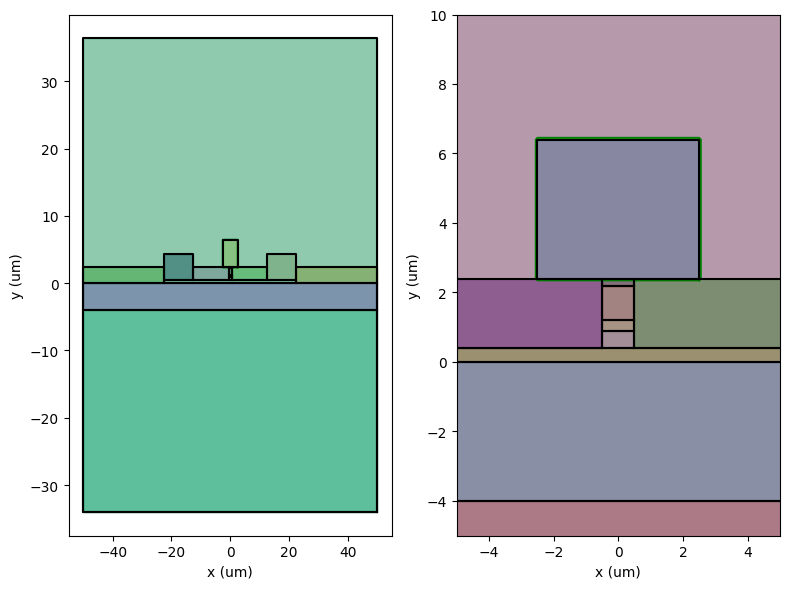

In [2]:
eopm = InP_EOPM()
eopm._make_meshes()
eopm._create_polygons()
eopm._initialize_device()

fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

for ax in [ax1, ax2]:
    eopm.device.plot_polygons(
        color_polygon="black",
        color_line="green",
        color_junctions="blue",
        fill_polygons=True,
        fig=fig,
        ax=ax,
    )

ax2.set_xlim(-5,5)
ax2.set_ylim(-5,10)

ax1.set_xlabel('x (um)')
ax1.set_ylabel('y (um)')
ax2.set_xlabel('x (um)')
ax2.set_ylabel('y (um)')

plt.tight_layout()
plt.show()

## Find the optical mode

(<Figure size 640x480 with 1 Axes>, <Axes: >)

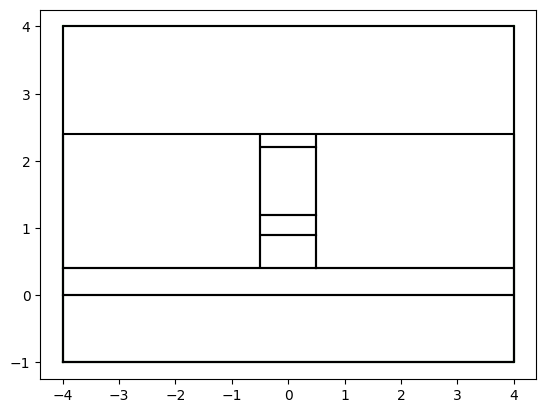

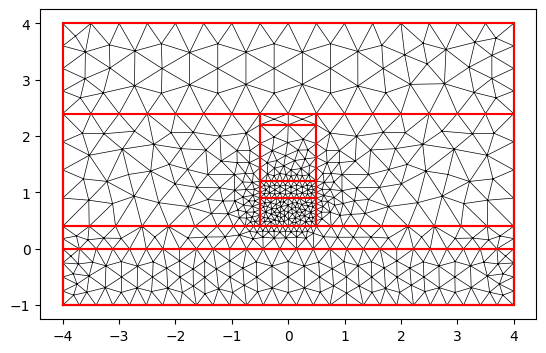

In [3]:
mode = OpticalSimulatorFEMWELL(
    device=eopm.device,
    simulation_window=shapely.box(-4,-1,4,4),
    include_metals=False
)

mode.plot_polygons()

mode.make_mesh()

mode.plot_mesh()


To get nicer results, we will do a mesh refinement step.

Effective index - mode 0: 3.2990
loss - mode 0: 59462.25 dB/cm
#------------------------------------------#
Effective index - mode 1: 3.2494
loss - mode 1: 49129.62 dB/cm
#------------------------------------------#
Effective index - mode 2: 3.2201
loss - mode 2: 8.15 dB/cm
#------------------------------------------#
Effective index - mode 3: 3.2179
loss - mode 3: 4.05 dB/cm
#------------------------------------------#
Effective index - mode 4: 3.0602
loss - mode 4: 2339.77 dB/cm
#------------------------------------------#


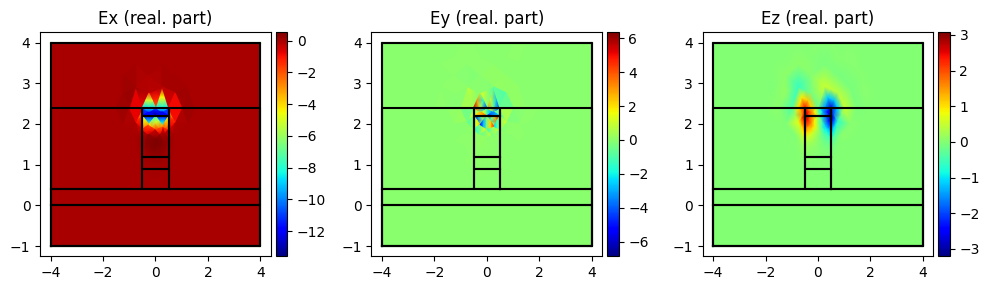

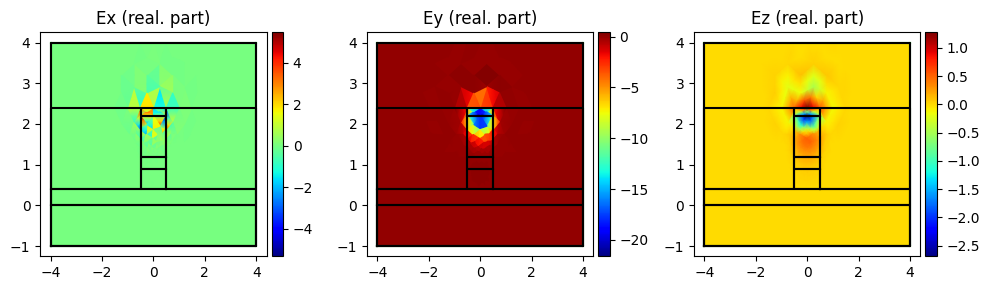

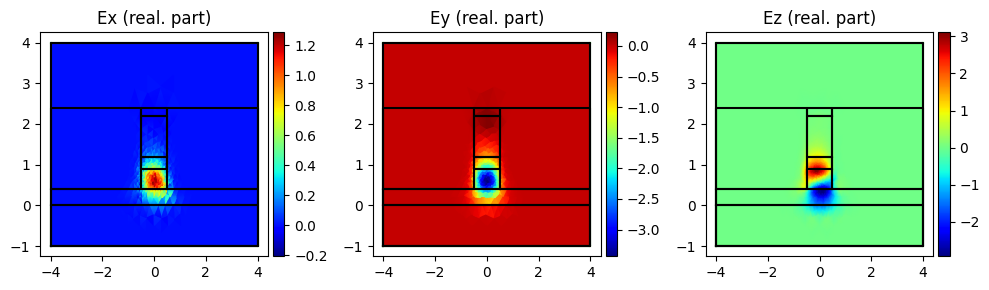

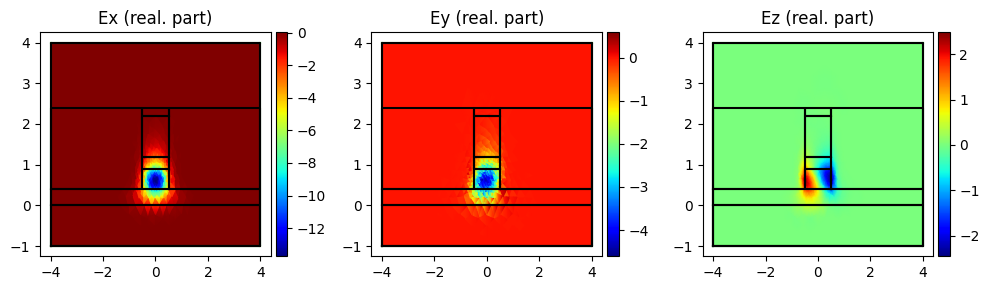

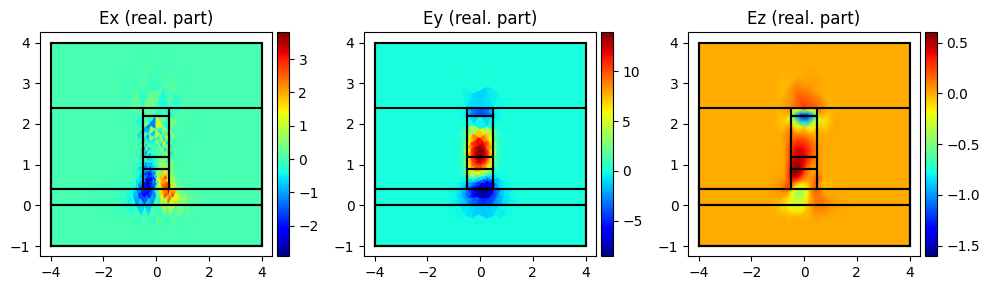

In [4]:
modes = mode.compute_modes(
    wavelength=1.55,
    num_modes=5,
    order=1,
    metallic_boundaries=False,
    n_guess=3.5,
    return_modes=True
)

for i in range(len(modes)):
    print(f'Effective index - mode {i}: {modes[i].n_eff.real:.4f}')
    print(f'loss - mode {i}: {modes[i].calculate_propagation_loss(1e4):.2f} dB/cm')
    print('#------------------------------------------#')

for i in range(len(modes)):
    mode.plot_mode(
        mode=modes[i],
    )

In [5]:
neff = []
loss = []
nelements = []

mode.make_mesh()
for i in range(30):
    print(f'--- Refinement iteration {i} ---')

    mode.compute_modes(
        wavelength=1.55,
        num_modes=3,
        order=1,
        metallic_boundaries=False,
        n_guess=3.5,
        return_modes=True
    )

    loss_tmp = []
    for opt_mode in mode.modes:
        loss_tmp.append(opt_mode.calculate_propagation_loss(1e4))

    idx_mode = np.argmin(np.abs(loss_tmp))
    # print('Selected mode index for refinement:', idx_mode)
    # print('Loss of se:', loss_tmp)

    nelements.append(mode.mesh.nelements)
    neff.append(mode.modes[idx_mode].n_eff.real)
    loss.append(mode.modes[idx_mode].calculate_propagation_loss(1e4))

    mode.refine_mesh(mode_for_refinement=mode.modes[idx_mode])

    print(f'neff: {neff[-1]:.6f}, loss: {loss[-1]:.2f} dB/cm, nelements: {nelements[-1]}')

--- Refinement iteration 0 ---
neff: 3.217871, loss: 4.05 dB/cm, nelements: 1061
--- Refinement iteration 1 ---
neff: 3.217228, loss: 3.64 dB/cm, nelements: 1101
--- Refinement iteration 2 ---
neff: 3.212777, loss: 4.17 dB/cm, nelements: 1255
--- Refinement iteration 3 ---
neff: 3.215660, loss: 9.88 dB/cm, nelements: 1429
--- Refinement iteration 4 ---
neff: 3.215910, loss: 10.84 dB/cm, nelements: 1573
--- Refinement iteration 5 ---
neff: 3.212015, loss: 5.02 dB/cm, nelements: 1895
--- Refinement iteration 6 ---
neff: 3.215393, loss: 11.67 dB/cm, nelements: 2075
--- Refinement iteration 7 ---
neff: 3.215521, loss: 11.68 dB/cm, nelements: 2299
--- Refinement iteration 8 ---
neff: 3.214702, loss: 12.46 dB/cm, nelements: 2823
--- Refinement iteration 9 ---
neff: 3.208150, loss: 5.39 dB/cm, nelements: 3639
--- Refinement iteration 10 ---
neff: 3.207441, loss: 5.48 dB/cm, nelements: 3849
--- Refinement iteration 11 ---
neff: 3.206677, loss: 5.57 dB/cm, nelements: 4173
--- Refinement iterati

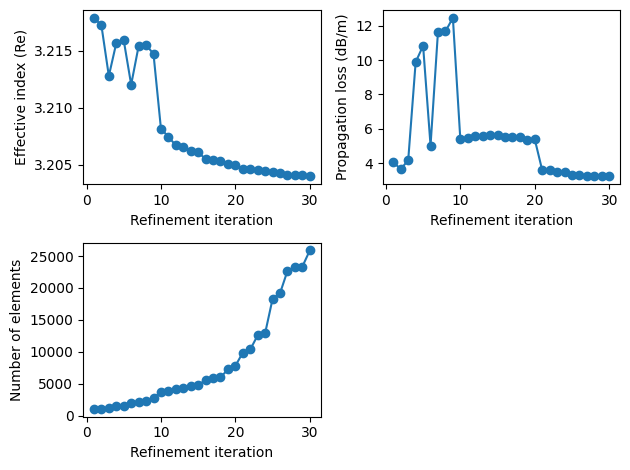

In [6]:
fig = plt.figure()
gs = fig.add_gridspec(2, 2)

n_iterations = np.arange(len(nelements))+1

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])

ax1.plot(n_iterations, neff, marker='o')
ax2.plot(n_iterations, loss, marker='o')
ax3.plot(n_iterations, nelements, marker='o')

ax1.set_xlabel('Refinement iteration')
ax2.set_xlabel('Refinement iteration')
ax3.set_xlabel('Refinement iteration')

ax1.set_ylabel('Effective index (Re)')
ax2.set_ylabel('Propagation loss (dB/m)')
ax3.set_ylabel('Number of elements')

plt.tight_layout()
plt.show()

(<Figure size 640x480 with 1 Axes>, <Axes: >)

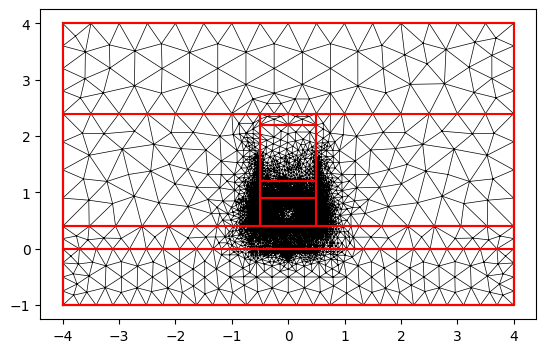

In [7]:
mode.plot_mesh()

Effective index - mode 0: 3.2451
loss - mode 0: 57154.94 dB/cm
#------------------------------------------#
Effective index - mode 1: 3.2109
loss - mode 1: 8.53 dB/cm
#------------------------------------------#
Effective index - mode 2: 3.2040
loss - mode 2: 3.23 dB/cm
#------------------------------------------#
Effective index - mode 3: 3.1848
loss - mode 3: 43124.54 dB/cm
#------------------------------------------#
Effective index - mode 4: 3.0481
loss - mode 4: 2559.31 dB/cm
#------------------------------------------#


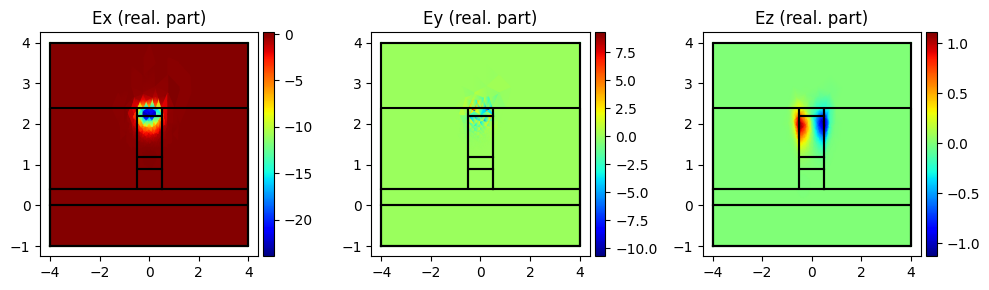

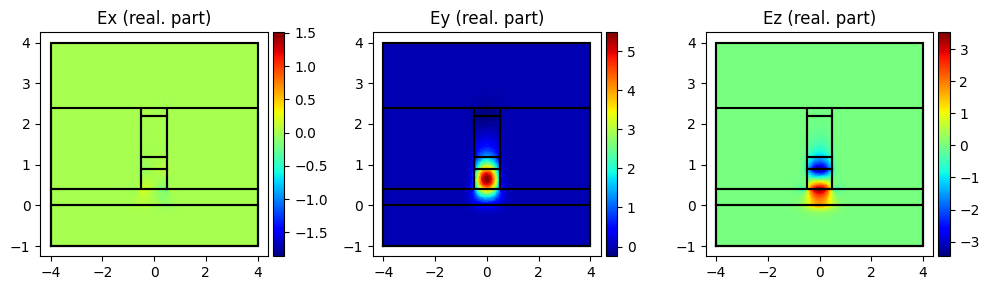

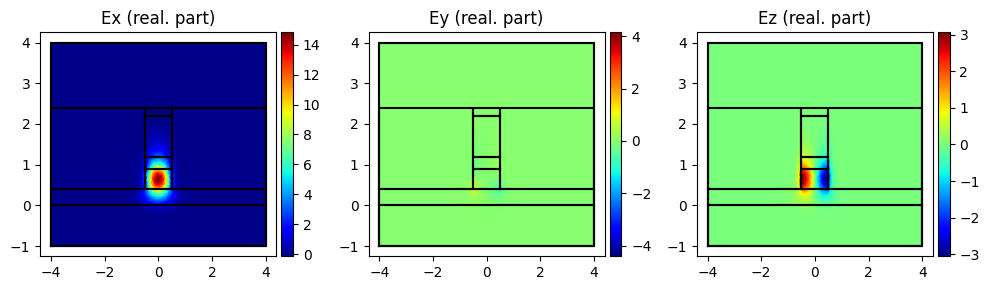

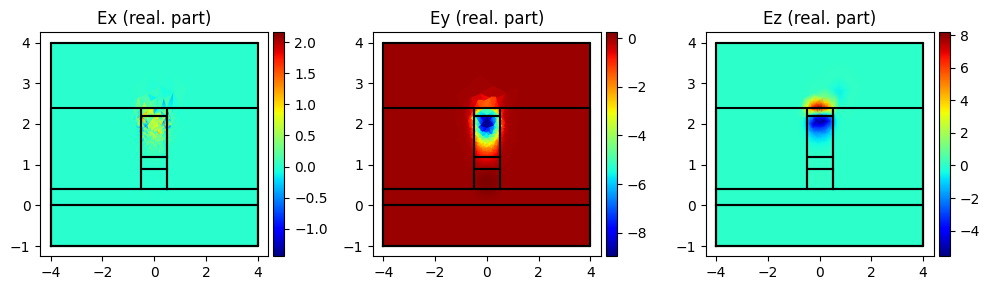

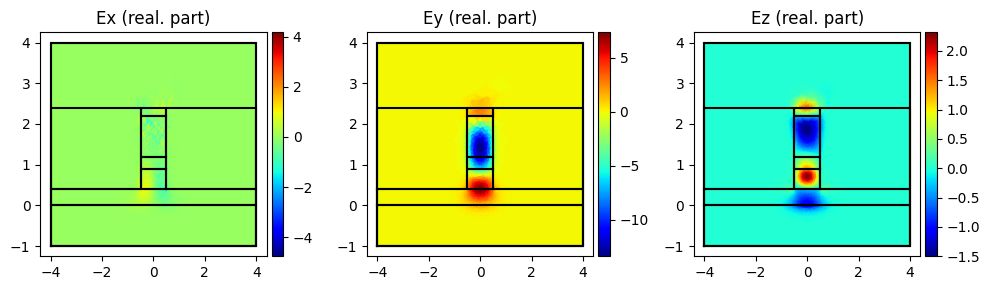

In [8]:
modes = mode.compute_modes(
        wavelength=1.55,
        num_modes=5,
        order=1,
        metallic_boundaries=False,
        n_guess=3.5,
        return_modes=True
    )

for i in range(len(modes)):
    print(f'Effective index - mode {i}: {modes[i].n_eff.real:.4f}')
    print(f'loss - mode {i}: {modes[i].calculate_propagation_loss(1e4):.2f} dB/cm')
    print('#------------------------------------------#')

for i in range(len(modes)):
    mode.plot_mode(
        mode=modes[i],
    )

Now that we have found our modes, we will transfer the TE and TM modes to the `PhotonicDevice`:

In [9]:
mode.transfer_results_to_device(
    TE_TM_idx=[2,1]
)

c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\skfem\assembly\form\linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


## Solve the charge transport equations

Charge transport will take place with:
p2
p1
wg2
wg1
n


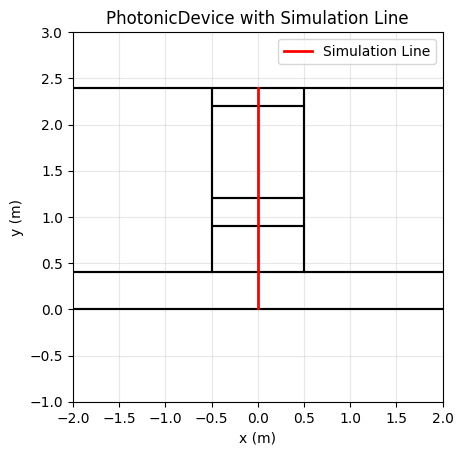

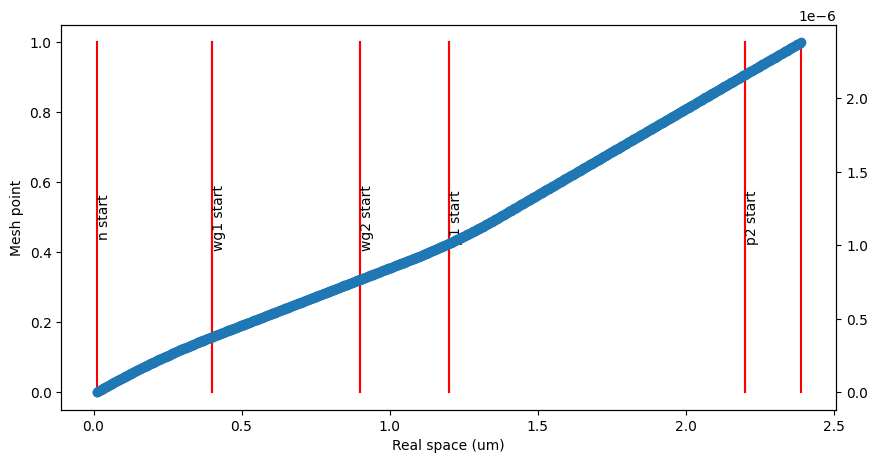

In [10]:
a=shapely.LineString([
    [0,0+0.01],
    [0,eopm.h_n+eopm.h_wg1+eopm.h_wg2+eopm.h_p1+eopm.h_p2 - 0.01]]) #simulation line

charge=ChargeSimulatorSolcore(
    device=eopm.device,
    simulation_line=a,
    bias_start_stop_step=[0,6,21]
)

fig, ax = charge.plot_with_simulation_line()

ax.set_xlim(-2,2)
ax.set_ylim(-1,3)

charge.plot_mesh()
plt.show()

Material "n" does not have k-data defined. Returning "zeros"
Material "wg1" does not have k-data defined. Returning "zeros"
Material "wg2" does not have k-data defined. Returning "zeros"
Material "p1" does not have k-data defined. Returning "zeros"
Material "p2" does not have k-data defined. Returning "zeros"
Solving IV of the junctions...


c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\solcore\sesame_drift_diffusion\solve_pdd.py:193: UserWarning: All voltages are positive, but junction has been identified as n-p, so the  open-circuit voltage (Voc) of the junction will be negative.
  warnings.warn(


Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


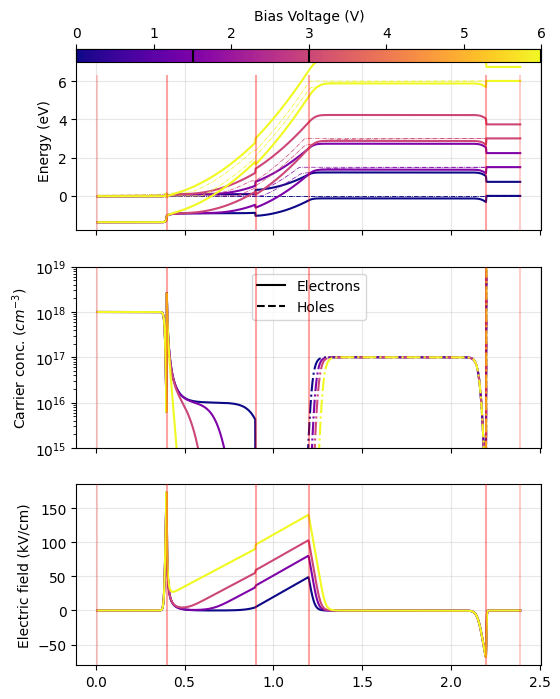

In [11]:
charge.solve_PDD(
    verbose = True*0,
    tol = 1e-6,
    max_iter = 1000,
    smooth_output=True*0,
)

charge.plot_results(
    V_idx = [0, 5, 10, 20],
    cmap = 'plasma'
    )

And now we transfer again the results to the ``PhotonicDevice`

In [12]:
charge.transfer_results_to_device(xmin=-2, xmax=2, dx = 0.01)

## Calculate the electro optic response

We now have all the data necessary to perform the electro-optic calculations. We start by initializing the `ElectroOpticSimulator`

Text(0, 0.5, 'y (um)')

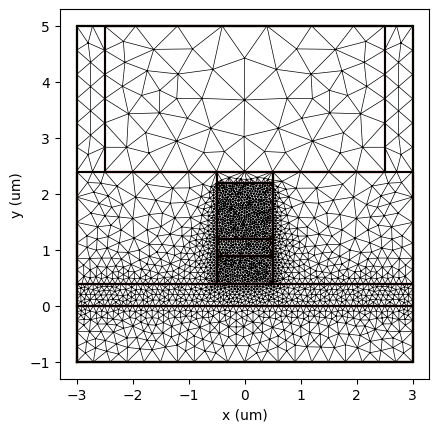

In [13]:
EO=ElectroOpticalSimulator(
	device=eopm.device,
	simulation_window=shapely.box(-3,-1,3,5)
	)

EO.make_mesh()

fig, ax = EO.plot_mesh()
EO.plot_polygons(ax=ax)

ax.set_xlabel('x (um)')
ax.set_ylabel('y (um)')

We can now calculate the $\Delta \bar{\epsilon}(x,y,V)$

In [14]:
EO.get_epsilon_optical()

c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\pint\facets\numpy\numpy_func.py:322: RuntimeWarning: invalid value encountered in sqrt
  result_magnitude = func(*stripped_args, **stripped_kwargs)
c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\pint\facets\plain\quantity.py:1271: RuntimeWarning: invalid value encountered in power
  magnitude = new_self._magnitude**exponent
c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\pint\facets\plain\quantity.py:1271: RuntimeWarning: invalid value encountered in sqrt
  magnitude = new_self._magnitude**exponent
c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\pint\facets\plain\quantity.py:1006: RuntimeWarning: divide by zero encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\pint\facets\plain\quantity.py:1

It is instructive to understand the structure of the `EO.epsilon_optical` object as it became quite complex out of necessity to allow for future models. This object is stored as a dictionary. Each key of this dictionary aims to capture the effects induced by an `ElectroOpticalModel`. In our case we have only `InGaAsPElectroOpticalModel`:

In [15]:
EO.epsilon_optical.keys()

dict_keys(['InGaAsPElectroOpticalModel'])

Now, each key to an `ElectroOpticalModel` is again a dictionary because it can happen that a single `ElectroOpticalModel` has various contributions to the overall electro-optic response. For example, the `InGaAsPElectroOpticalModel` has 5 different contributions: 3 charge effects (plasma, band-filling and intervalence effects) and 2 field effects (pockels and kerr). It may be useful for you, as a designer to account for this distinction. For example if you design for 100GHz+ you may want to focus on optimizing field effects rather than charge effects since they are fundamentally limited. If you are designing for lower frequencies you may be interested in a balance between charge effects and field effects. The structure of this nested dictionary gives you two keys: `dperms` and `labels`. The `dperms` are the actual changes in permitivity induced by the various effects, and the `labels` is just a list which lets you retrieve the `dperm` for each of the effects. The `dperms` array has a shape of the shape [3,3,mesh points, voltage values, effects].

In [16]:
print(EO.epsilon_optical['InGaAsPElectroOpticalModel'].keys())
print(EO.epsilon_optical['InGaAsPElectroOpticalModel']['dperms'].shape)
print(EO.epsilon_optical['InGaAsPElectroOpticalModel']['labels'])

dict_keys(['dperms', 'labels'])
(3, 3, 2247, 21, 5)
['Bandfilling', 'Plasma', 'Intervalence', 'Pockels', 'Kerr']


Armed with this information we can actually inspect the $\Delta \bar{\epsilon}$ for the various effects:

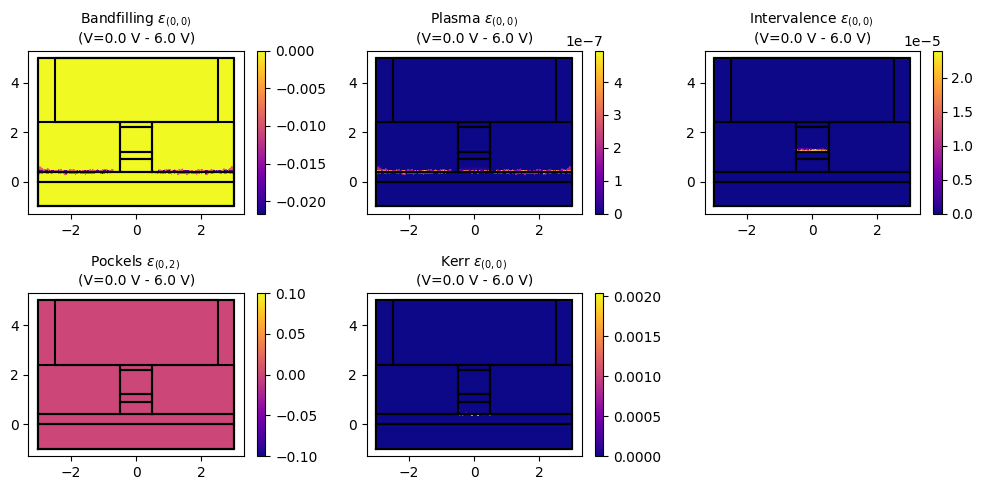

In [17]:
# Here we will inspect some of the calculated properties
# We know we are working with InGaAsP materials so we'll focus on those ElectroOpticalModel properties

V_values = list(eopm.device.charge['V'])
idx_voltage1 = -1
idx_voltage2 = 0

fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(2, 3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])

axes = [ax1, ax2, ax3, ax4, ax5]

tensor_elements = [
    (0,0),
    (0,0),
    (0,0),
    (0,2),
    (0,0)
]

for idx_effect in range(5):
    e11,e22 = tensor_elements[idx_effect]
    eps1 = EO.epsilon_optical['InGaAsPElectroOpticalModel']['dperms'][e11,e22, :, idx_voltage1, idx_effect]
    eps2 = EO.epsilon_optical['InGaAsPElectroOpticalModel']['dperms'][e11,e22, :, idx_voltage2, idx_effect]
    label = EO.epsilon_optical['InGaAsPElectroOpticalModel']['labels'][idx_effect]

    ax = axes[idx_effect]

    EO.basis.plot((eps2 - eps1).imag, ax=ax, cmap='plasma', colorbar=True)
    # scat= ax.scatter(
    #     EO.mesh.p[0],
    #     EO.mesh.p[1],
    #     c=(eps2 - eps1).imag,
    # )
    # fig.colorbar(scat, ax=ax, label=f'Imaginary part of $\\Delta \\epsilon_{{{e11,e22}}}$')
    ax.set_title(f'{label} $\\epsilon_{{{e11,e22}}}$ \n(V={V_values[idx_voltage2]} V - {V_values[idx_voltage1]} V)', fontsize=10)

    EO.plot_polygons(fig = fig, ax=ax)


fig.tight_layout()

Finally, we can calculate the electro-optic response, considering the overlap with the optical field. In the following, we will consider the following:

- We are intered in phase modulation of the TE and TM modes. Cross modulation will be explored in another tutorial.
- We will rotate the permitivity around the y axis by 45deg so that the contribution of the pockels effect is positive.
- We will calculate the electro-optic response with respect to 0V.

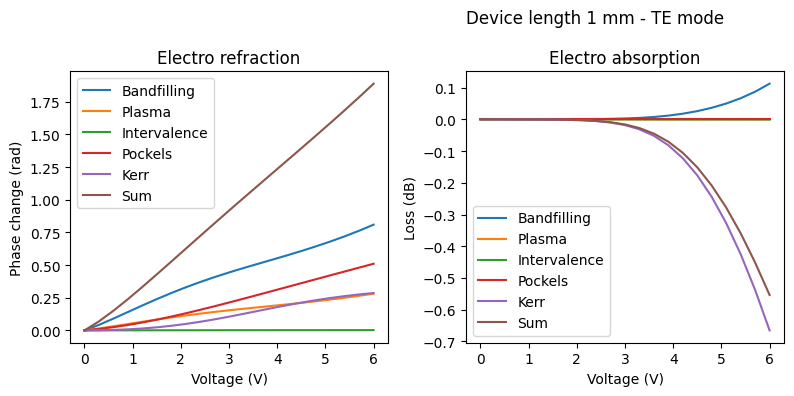

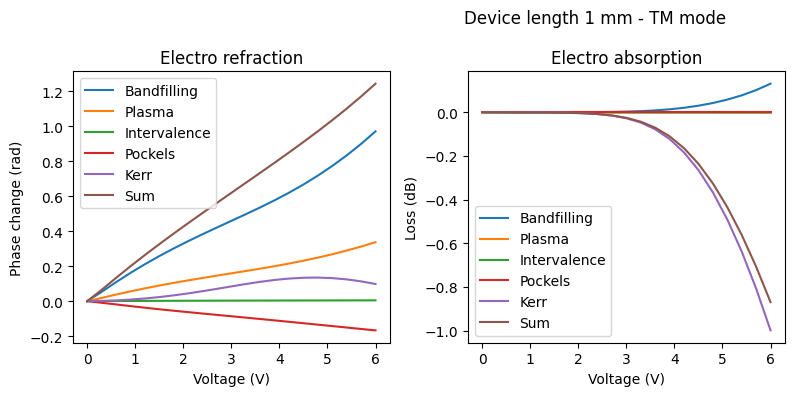

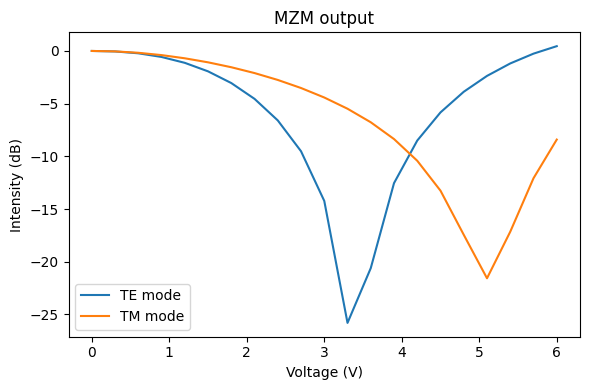

In [18]:
#Calculate the EO response for all voltages
all_res_TE = []
all_res_TM = []

for i in range(len(eopm.device.charge['V'])):
    kappa_aa = EO.calculate_EO_response(
        voltage_idx=i,
        rot_x=0,
        rot_y=np.pi/4,
        rot_z=0,
        base_epsilon_voltage_idx=0,
        optical_mode_a='TE',
        optical_mode_b='TE',
    )

    kappa_bb = EO.calculate_EO_response(
        voltage_idx=i,
        rot_x=0,
        rot_y=np.pi/4,
        rot_z=0,
        base_epsilon_voltage_idx=0,
        optical_mode_a='TM',
        optical_mode_b='TM',
    )

    ## Adjust to have phase change

    all_res_TE.append(kappa_aa['InGaAsPElectroOpticalModel']['results'])
    all_res_TM.append(kappa_bb['InGaAsPElectroOpticalModel']['results'])
    # print(res['InGaAsPElectroOpticalModel']['results'].real*1e-3)
all_res_TE = np.asarray(all_res_TE)
all_res_TM = np.asarray(all_res_TM)

for all_res, title in zip([all_res_TE, all_res_TM], ['TE', 'TM']):
    fig = plt.figure(figsize = (12,4))

    gs = fig.add_gridspec(1, 3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    for i in range(5):
        ax1.plot(V_values, np.real(all_res[:,i]*1e-3), label=f'{kappa_aa["InGaAsPElectroOpticalModel"]["labels"][i]}')

    ax1.plot(V_values, np.sum(np.real(all_res), axis=1)*1e-3, label='Sum')
    ax1.legend()
    ax1.set_xlabel('Voltage (V)')
    ax1.set_ylabel('Phase change (rad)')
    ax1.set_title('Electro refraction')

    for i in range(5):
        conversion_factor = 20 * np.log10(np.e)  # ≈ 8.686
        ax2.plot(V_values, np.imag(all_res[:,i]*1e-3)*conversion_factor, label=f'{kappa_aa["InGaAsPElectroOpticalModel"]["labels"][i]}')

    ax2.plot(V_values, np.sum(np.imag(all_res)*1e-3, axis=1)*conversion_factor, label='Sum')
    ax2.legend()
    ax2.set_xlabel('Voltage (V)')
    ax2.set_ylabel('Loss (dB)')
    ax2.set_title('Electro absorption')

    fig.suptitle(f'Device length 1 mm - {title} mode')
    fig.tight_layout()

fig = plt.figure(figsize = (6,4))
ax3 = fig.add_subplot(1,1,1)

for all_res, title in zip([all_res_TE, all_res_TM], ['TE', 'TM']):
    Eout = 1/2 * (1 + np.exp(1j*np.sum(all_res*3e-3, axis=1)))
    Iout = np.abs(Eout)**2

    ax3.plot(V_values, 10*np.log10(Iout), label = f'{title} mode')
ax3.set_xlabel('Voltage (V)')
ax3.set_ylabel('Intensity (dB)')
ax3.set_title('MZM output')
ax3.legend()

fig.tight_layout()

At this point it is important that we analyze the data. A very worrying feature has popped up in the results above: the Kerr effect seems to be inducing gain. This is not physical since the kerr effect will start inducing loss rather than gain at 1550nm with high voltage, and we must understand why. As far as we know, when this happens it is usually something to do with bad data rather than wrong mathematics (but it can happen! If you find a mistake, please let us know). In this case, when analyze the effects in the previous step, we find that there seems to be something happening at the InGaAsP/InP boundary. Not only there is a big charge depletion as there also exist a sudden change in the band energies both of which impact greatly the Kerr effect in InGaAsP alloys. This is where optimizing the PDD solver is crucial, as these details can completely change the behaviour of your electro-optical modulator, and you must be aware of your structure and if such barriers are actually physical. In our case, we have found that a simple smoothing of the data from the PDD solver return physically sensible results

## Correcting PDD data

Charge transport will take place with:
p2
p1
wg2
wg1
n
Material "n" does not have k-data defined. Returning "zeros"
Material "wg1" does not have k-data defined. Returning "zeros"
Material "wg2" does not have k-data defined. Returning "zeros"
Material "p1" does not have k-data defined. Returning "zeros"
Material "p2" does not have k-data defined. Returning "zeros"
Solving IV of the junctions...


c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\solcore\sesame_drift_diffusion\solve_pdd.py:193: UserWarning: All voltages are positive, but junction has been identified as n-p, so the  open-circuit voltage (Voc) of the junction will be negative.
  warnings.warn(


Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


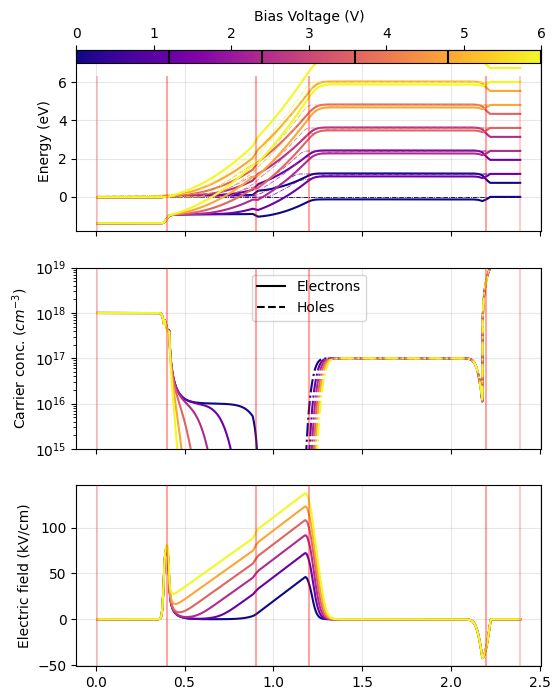

In [19]:
a=shapely.LineString([
    [0,0+0.01],
    [0,eopm.h_n+eopm.h_wg1+eopm.h_wg2+eopm.h_p1+eopm.h_p2 - 0.01]]) #simulation line

charge=ChargeSimulatorSolcore(
    device=eopm.device,
    simulation_line=a,
    bias_start_stop_step=[0,6,51]
)

charge.solve_PDD(
    verbose = True*0,
    tol = 1e-6,
    max_iter = 1000,
    smooth_output=True,
)

charge.plot_results(
    V_idx = [0, 10, 20, 30, 40, 50],
    cmap = 'plasma'
    )

In [20]:
charge.transfer_results_to_device(xmin=-2, xmax=2, dx = 0.01)

c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\pint\facets\numpy\numpy_func.py:322: RuntimeWarning: invalid value encountered in sqrt
  result_magnitude = func(*stripped_args, **stripped_kwargs)
c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\pint\facets\plain\quantity.py:1006: RuntimeWarning: divide by zero encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\pint\facets\plain\quantity.py:1006: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
C:\Users\20230622\OneDrive - TU Eindhoven\PhD\Python packages\photonmod\src\imodulator\ElectroOpticalSimulator.py:367: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  epsilon_optical_all[EO_model_name]['dperms'][:, :, vertices_idxs, voltage_idx, perm_idx] = p

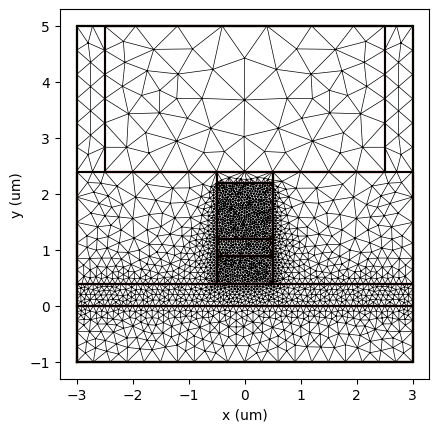

In [21]:
EO=ElectroOpticalSimulator(
	device=eopm.device,
	simulation_window=shapely.box(-3,-1,3,5)
	)

EO.make_mesh()

fig, ax = EO.plot_mesh()
EO.plot_polygons(ax=ax)

ax.set_xlabel('x (um)')
ax.set_ylabel('y (um)')

EO.get_epsilon_optical()

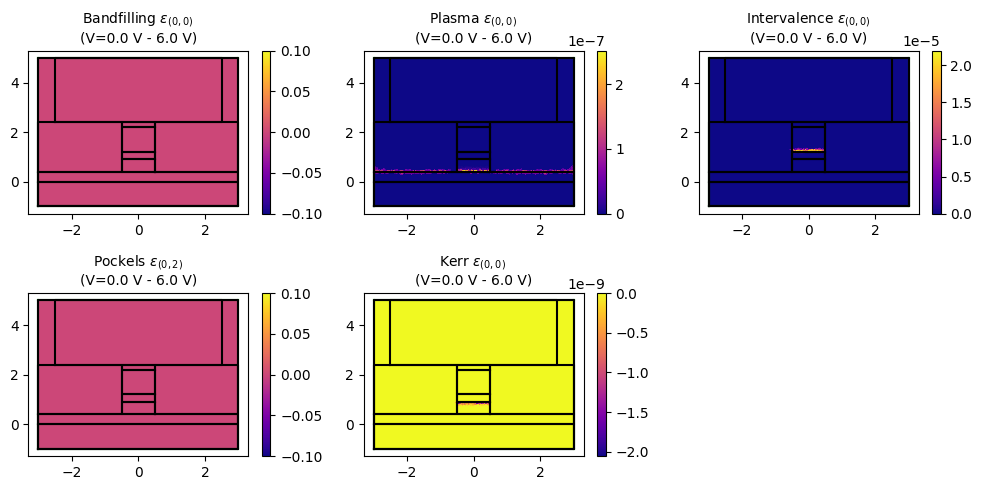

In [22]:
# Here we will inspect some of the calculated properties
# We know we are working with InGaAsP materials so we'll focus on those ElectroOpticalModel properties

V_values = list(eopm.device.charge['V'])
idx_voltage1 = -1
idx_voltage2 = 0

fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(2, 3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])

axes = [ax1, ax2, ax3, ax4, ax5]

tensor_elements = [
    (0,0),
    (0,0),
    (0,0),
    (0,2),
    (0,0)
]

for idx_effect in range(5):
    e11,e22 = tensor_elements[idx_effect]
    eps1 = EO.epsilon_optical['InGaAsPElectroOpticalModel']['dperms'][e11,e22, :, idx_voltage1, idx_effect]
    eps2 = EO.epsilon_optical['InGaAsPElectroOpticalModel']['dperms'][e11,e22, :, idx_voltage2, idx_effect]
    label = EO.epsilon_optical['InGaAsPElectroOpticalModel']['labels'][idx_effect]

    ax = axes[idx_effect]

    EO.basis.plot((eps2 - eps1).imag, ax=ax, cmap='plasma', colorbar=True)
    # scat= ax.scatter(
    #     EO.mesh.p[0],
    #     EO.mesh.p[1],
    #     c=(eps2 - eps1).imag,
    # )
    # fig.colorbar(scat, ax=ax, label=f'Imaginary part of $\\Delta \\epsilon_{{{e11,e22}}}$')
    ax.set_title(f'{label} $\\epsilon_{{{e11,e22}}}$ \n(V={V_values[idx_voltage2]} V - {V_values[idx_voltage1]} V)', fontsize=10)

    EO.plot_polygons(fig = fig, ax=ax)


fig.tight_layout()

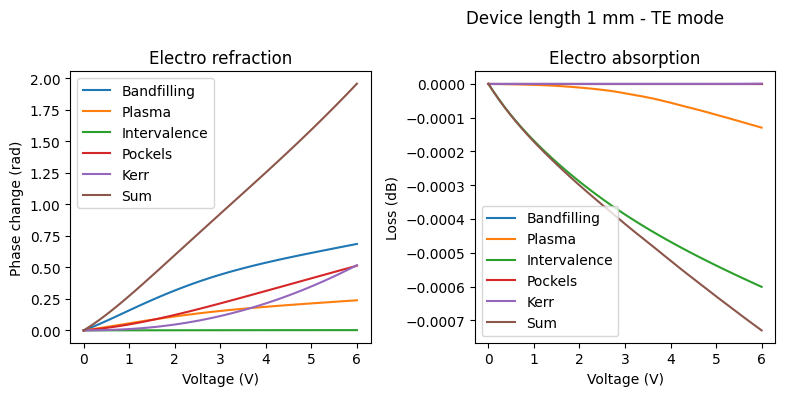

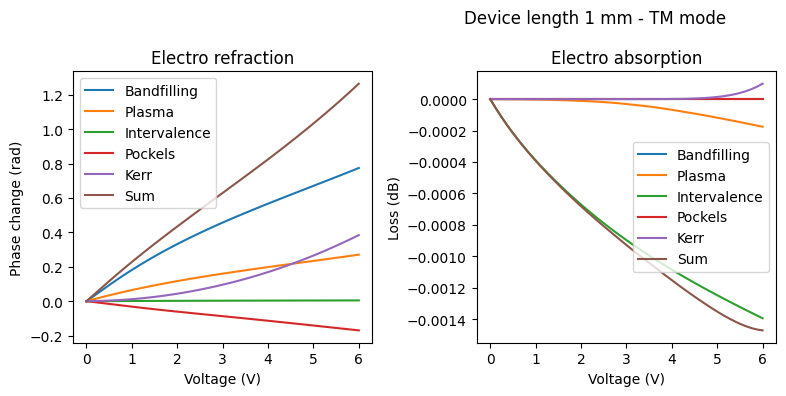

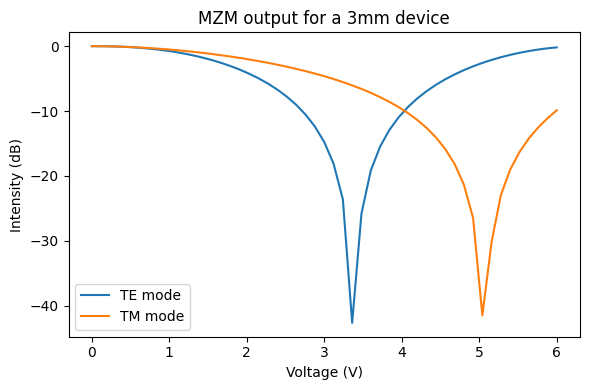

In [23]:
#Calculate the EO response for all voltages
all_res_TE = []
all_res_TM = []

for i in range(len(eopm.device.charge['V'])):
    kappa_aa = EO.calculate_EO_response(
        voltage_idx=i,
        rot_x=0,
        rot_y=np.pi/4,
        rot_z=0,
        base_epsilon_voltage_idx=0,
        optical_mode_a='TE',
        optical_mode_b='TE',
    )

    kappa_bb = EO.calculate_EO_response(
        voltage_idx=i,
        rot_x=0,
        rot_y=np.pi/4,
        rot_z=0,
        base_epsilon_voltage_idx=0,
        optical_mode_a='TM',
        optical_mode_b='TM',
    )

    ## Adjust to have phase change

    all_res_TE.append(kappa_aa['InGaAsPElectroOpticalModel']['results'])
    all_res_TM.append(kappa_bb['InGaAsPElectroOpticalModel']['results'])
    # print(res['InGaAsPElectroOpticalModel']['results'].real*1e-3)
all_res_TE = np.asarray(all_res_TE)
all_res_TM = np.asarray(all_res_TM)

for all_res, title in zip([all_res_TE, all_res_TM], ['TE', 'TM']):
    fig = plt.figure(figsize = (12,4))

    gs = fig.add_gridspec(1, 3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    for i in range(5):
        ax1.plot(V_values, np.real(all_res[:,i]*1e-3), label=f'{kappa_aa["InGaAsPElectroOpticalModel"]["labels"][i]}')

    ax1.plot(V_values, np.sum(np.real(all_res), axis=1)*1e-3, label='Sum')
    ax1.legend()
    ax1.set_xlabel('Voltage (V)')
    ax1.set_ylabel('Phase change (rad)')
    ax1.set_title('Electro refraction')

    for i in range(5):
        conversion_factor = 20 * np.log10(np.e)  # ≈ 8.686
        ax2.plot(V_values, np.imag(all_res[:,i]*1e-3)*conversion_factor, label=f'{kappa_aa["InGaAsPElectroOpticalModel"]["labels"][i]}')

    ax2.plot(V_values, np.sum(np.imag(all_res)*1e-3, axis=1)*conversion_factor, label='Sum')
    ax2.legend()
    ax2.set_xlabel('Voltage (V)')
    ax2.set_ylabel('Loss (dB)')
    ax2.set_title('Electro absorption')

    fig.suptitle(f'Device length 1 mm - {title} mode')
    fig.tight_layout()

fig = plt.figure(figsize = (6,4))
ax3 = fig.add_subplot(1,1,1)

for all_res, title in zip([all_res_TE, all_res_TM], ['TE', 'TM']):
    Eout = 1/2 * (1 + np.exp(1j*np.sum(all_res*3e-3, axis=1)))
    Iout = np.abs(Eout)**2

    ax3.plot(V_values, 10*np.log10(Iout), label = f'{title} mode')
ax3.set_xlabel('Voltage (V)')
ax3.set_ylabel('Intensity (dB)')
ax3.set_title('MZM output for a 3mm device')
ax3.legend()

fig.tight_layout()

We now have a far more sensible solution. With this, we can now make some conclusions:

- As you can see, in these kind of modulators, there is quite a significant contribution from the charge effects. 
- There seems to be some gain from the intervalence effects. This is something that is visible even in experiments. The origin of it stems from the depletion of p dopants from the depletion region. These have a very strong absorption, and even depleting a few carriers can make a significant contribution to the change in loss.
- The TM and TE mode have very distinct $V_\pi$. This stems from the difference in the effect that the pockels effect has.
- The TM mode does not have a 0 contribution from the pockels effect. This stems from the fact that our TE and TM modes are not pure TE and pure TM, so we are bound to have some cross modulation. The fact that the pockels contribution of the TM mode is negative tells us that the ersponsible for it is the Z component of the field rather than the x component. 